In [552]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carga de liberias y datos

In [553]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Descargar recursos adicionales de NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Cargar los datos de entrenamiento y test
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        tweets = file.readlines()
    return tweets

train_tweets = load_data('/content/drive/MyDrive/PLN-2022-2023/VIERNES/TRABAJO - ENTREGA/training.txt')
test_tweets = load_data('/content/drive/MyDrive/PLN-2022-2023/VIERNES/TRABAJO - ENTREGA/test.txt')

# Creamos los DataFrames con los tweets tanto para train como para test
df_train_tweets = pd.DataFrame([tweet.split('\t') for tweet in train_tweets], columns=['Id', 'Sentimiento', 'Texto'])
df_test_tweets = pd.DataFrame([tweet.split('\t') for tweet in test_tweets], columns=['Id', 'Sentimiento', 'Texto'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Visualizamos el train y el test**

In [554]:
df_train_tweets

,Id,Sentimiento,Texto
0,768213876278165504,NONE,-Me caes muy bien -Tienes que jugar más parti...
1,768213567418036224,N,@myendlesshazza a. que puto mal escribo b. me...
2,768212591105703936,N,@estherct209 jajajaja la tuya y la d mucha gen...
3,768221670255493120,P,Quiero mogollón a @AlbaBenito99 pero sobretodo...
4,768221021300264964,N,Vale he visto la tia bebiendose su regla y me ...
...,...,...,...
1003,814846333601320960,P,Para mí mi mejor año fue el 2015 \n
1004,813731371076243461,N,Hoy va a ser un dia muy largo... \n
1005,818399956792905728,NEU,11:11 que no me encuentre mal \n
1006,815715581878009858,P,Es que son muy bonitas jo \n


In [555]:
df_test_tweets

,Id,Sentimiento,Texto
0,770567971701940224,UNK,@LonelySoad mientras que no te pillen la prime...
1,770503386789711872,UNK,@ceemeese ya era hora de volver al csgo y deja...
2,770502863017635840,UNK,@mireiaescribano justo cuando se terminan las ...
3,770599972102348800,UNK,@LuisMartinez22_ pensba q iba a hacer @wxplosi...
4,770599962216390656,UNK,"@Vic_Phantomhive Si lo encuentro, sin compañer..."
...,...,...,...
1894,783252629644247040,UNK,@Bammz87 ya eres bueno a esto o qué? \n
1895,780350213345214465,UNK,@Radinosaurio yo soy asi con mis amigos pero ...
1896,780515334956646400,UNK,@ElTerral somos más felices sin ti \n
1897,780540843346231300,UNK,Que agobio tío que mala estoy \n


## Preprocesamiento de datos del tweets

In [556]:
# Función de preprocesamiento de tweets
def preprocess_tweet(tweet):
    # Convertir a minúsculas
    tweet = tweet.lower()
    # Eliminar emojis DE MOMENTO
    #tweet = re.sub(r'[\U00010000-\U0010ffff]', '', tweet)
    tweet = emoji.demojize(tweet, language='es')
    # Eliminar fechas
    tweet = re.sub(r'\d{1,2}[\/-]\d{1,2}(?:[\/-]\d{2,4})?|\d{1,2}\s+de\s+\w+\s+de\s+\d{4}', '',tweet)
    # Eliminar horas
    tweet = re.sub(r'\b\d{1,2}:\d{2}(?: [ap]\.?[mM]\.?| h)?\b', '', tweet)
    # Eliminar URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Eliminar emails
    tweet = re.sub(r'\S+@\S+', '',tweet)
    # Eliminar numeros decimales
    tweet = re.sub(r'\d+(?:[\.,]\d+)?', '',tweet)
    # Eliminar acronimos
    tweet = re.sub(r'\b[A-Z\.]+\b\.?', '',tweet)
    # Eliminar menciones de usuarios
    tweet = re.sub(r'@[\w_]+', '', tweet)
    # Eliminar menciones hashtags
    tweet = re.sub(r'#[\w_-]+','',tweet)
    # Eliminar signos de puntuación y caracteres especiales
    tweet = re.sub(r'\.{3}|[.,‘“"?¿!¡;:%+_]', ' ', tweet)
    # Eliminar palabras vacías (stop words)
    stop_words = set(stopwords.words('spanish'))
    #tweet_tokens = TweetTokenizer(reduce_len=True, preserve_case=False)
    tweet_tokens = nltk.word_tokenize(tweet)
    filtered_tweet = [word for word in tweet_tokens if word not in stop_words]
    #return filtered_tweet
    # Esto es si quisieramos ver los tokens unidos.
    processed_tweet = ' '.join(filtered_tweet)
    return processed_tweet

In [557]:
# Aplicar preprocesamiento a los tweets
df_train_tweets['Tweet_Procesado'] = df_train_tweets['Texto'].apply(preprocess_tweet)

In [558]:
df_train_tweets.head(16)

,Id,Sentimiento,Texto,Tweet_Procesado
0,768213876278165504,NONE,-Me caes muy bien -Tienes que jugar más parti...,-me caes bien -tienes jugar partidas lol russe...
1,768213567418036224,N,@myendlesshazza a. que puto mal escribo b. me...,puto mal escribo b sigo surrando help quedado ...
2,768212591105703936,N,@estherct209 jajajaja la tuya y la d mucha gen...,jajajaja d mucha gente seguro puedo melena muero
3,768221670255493120,P,Quiero mogollón a @AlbaBenito99 pero sobretodo...,quiero mogollón sobretodo rápido contesta wasaps
4,768221021300264964,N,Vale he visto la tia bebiendose su regla y me ...,vale visto tia bebiendose regla hs dado muchs ...
5,768220253730009091,P,@Yulian_Poe @guillermoterry1 Ah. mucho más por...,ah supuesto solo incluyo entendido mal
6,768224728049999872,N,Se ha terminado #Rio2016 Lamentablemente no ar...,terminado lamentablemente arriendo ganancias p...
7,768231706746912769,P,11. siiii fue super gracioso teniamos que habe...,siiii super gracioso teniamos habernos sacado ...
8,768231229439311872,N,@toNi_end seria mejor que dejasen de emitir es...,seria mejor dejasen emitir basura evolucionar ...
9,768231166965145600,N,"@jonoro96 te mandaria a comprarte un burro, pe...",mandaria comprarte burro creo tiendas abiertas...


In [559]:
# Obtener los valores únicos de la columna 'col1'
clases = df_train_tweets['Sentimiento'].unique()

# Imprimir los valores únicos
print(clases)

['NONE' 'N' 'P' 'NEU']


Vamos a crear un tokenizador sencillo

In [560]:
tknzr = TweetTokenizer(reduce_len=True, preserve_case=False)

In [561]:
#vec = TfidfVectorizer(tokenizer=tknzr.tokenize, analyzer="char", ngram_range=(2, 4), max_features=10000)
vec = CountVectorizer(tokenizer=tknzr.tokenize)
#vec = CountVectorizer(tokenizer=tknzr.tokenize, analyzer="char", ngram_range=(2, 4), max_features=10000)
X = vec.fit_transform(df_train_tweets['Tweet_Procesado'])
y = df_train_tweets['Sentimiento']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Entrenamos y Evaluamos el modelo

In [562]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [563]:
# Entrenar modelo
#modelo = RandomForestClassifier() #accuracy=0.49834983498349833 // accuracy_icons=0.46864686468646866
modelo = LogisticRegression(max_iter=1000,solver='newton-cholesky') #accuracy=0.504950495049505 // accuracy_icons=0.5115511551155115
#modelo = SVC(C=5,kernel='rbf') #accuracy=0.49174917491749176 // accuracy_icons=0.49504950495049505
#modelo = KNeighborsClassifier(n_neighbors=5)#accuracy=0.3432343234323432 // accuracy_icons=0.36633663366336633
modelo.fit(X_train, y_train)
# Predecir test
y_prediction = modelo.predict(X_test)

In [564]:
accuracy = accuracy_score(y_test, y_prediction)

In [565]:
# Imprimir la precisión
print("Precisión: ", accuracy)

Precisión:  0.5115511551155115


Metricas:
              precision    recall  f1-score   support

           N       0.54      0.79      0.64       134
         NEU       0.00      0.00      0.00        43
        NONE       0.40      0.11      0.17        37
           P       0.50      0.51      0.50        89

    accuracy                           0.51       303
   macro avg       0.36      0.35      0.33       303
weighted avg       0.43      0.51      0.45       303

Matriz de Confusión:


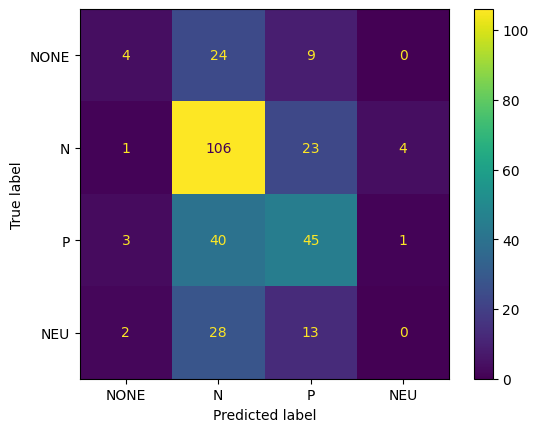

In [566]:
# Obtener la matriz de confusión
#cm = confusion_matrix(y_test, y_prediction)
cm = metrics.confusion_matrix(y_test, y_prediction, labels=clases)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clases)
# Imprimir la matriz de confusión
print("Metricas:")
print(metrics.classification_report(y_test, y_prediction))
print("Matriz de Confusión:")
disp.plot()
plt.show()

## Aprendizaje no supervisado:

In [600]:
def load_dic(filename):
    d = {}
    for line in open(filename):
        clean = line.strip()
        if len(clean) > 0 and clean[0] != '#':
            palabra, pol = clean.split()
            d[palabra] = pol
    return d

In [601]:
polarity_dic = load_dic("/content/drive/MyDrive/PLN-2022-2023/VIERNES/corpus/ElhPolar_esV1.lex")

In [602]:
def aprendizaje_NS(tweets):
  prediction = []
  for tweet in tweets:
      pos = neg = 0
      for word in tknzr.tokenize(tweet):
          if word in polarity_dic:
              if polarity_dic[word] == "positive":
                  pos += 1
              else:
                  neg += 1
      label = "NONE"
      if pos > neg:
          label = "P"
      elif neg > pos:
          label = "N"
      prediction.append(label)
  return prediction

In [603]:
y_testNS = df_train_tweets['Sentimiento']

In [604]:
y_predictionNS = aprendizaje_NS(df_train_tweets['Tweet_Procesado'])

In [605]:
accuracy = accuracy_score(y_testNS, y_predictionNS)

In [606]:
# Imprimir la precisión
print("Precisión: ", accuracy)

Precisión:  0.40476190476190477


Metricas:
              precision    recall  f1-score   support

           N       0.68      0.28      0.40       418
         NEU       0.00      0.00      0.00       133
        NONE       0.17      0.53      0.26       139
           P       0.52      0.68      0.59       318

    accuracy                           0.40      1008
   macro avg       0.34      0.37      0.31      1008
weighted avg       0.47      0.40      0.39      1008

Matriz de Confusión:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


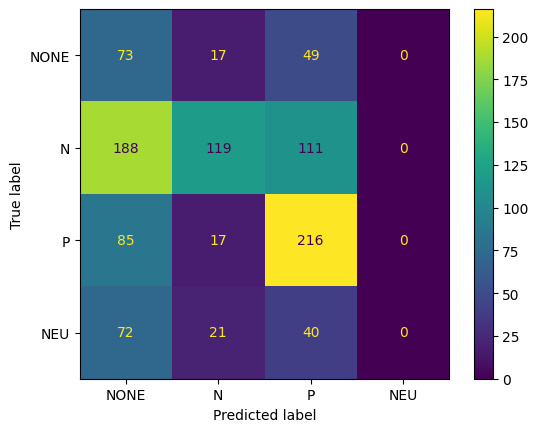

In [607]:
# Obtener la matriz de confusión
#cm = confusion_matrix(y_test, y_prediction)
cm = metrics.confusion_matrix(y_testNS, y_predictionNS, labels=clases)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clases)
# Imprimir la matriz de confusión
print("Metricas:")
print(metrics.classification_report(y_testNS, y_predictionNS))
print("Matriz de Confusión:")
disp.plot()
plt.show()